# Modeling the blade with polynomials

- The sides of the blade usually follow a nice degree 3 polynomial.
- The base can be modeled with a degree 4 polynomial.
- Combining then three different polynomials (one for each side + the base), we have a deterministic model of the blade's margin shape.
- We thus do not need to store the margin: we just need to store the polynomial coefficients and we can quickly recreate the shape.
- We can toggle some additional parameters so our modeling is as robust as possible, as some blades come with defects, either from the raw scan or the pre-processing stage:
    - Internal holes
    - The margins are bitten
    - Cuts and abrasions

## Load the usual libraries

- `os`: enable file manipulation with the OS
- `sys`: enable interaction with commandline
- `glob`: more variable manipulation
- `importlib:` Reload our own `.py`libraries
- `matplotlib.pyplot`: default plotter (I personally like ggplot waaaaay better. E)
    - `inline`: so that plots are shown in the notebook
- `numpy`: all number cruching done here
- `pandas`: data wrangling
- `scipy.ndimage`: basic image processing tools
- `tifffile`: save results as TIF files
- `PIL.Image`: manipulate JPGs

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import scipy.ndimage as ndimage
import tifffile as tf
import pandas as pd
import glob
import os
import importlib
%matplotlib inline

### Avoid clutter

- Additional functions are found in the `amaizeing_utils.py` file.
- Use `importlib.reload(maize)` to reflect changes in the `.py` file

In [2]:
import amaizeing_utils as maize
importlib.reload(maize)

<module 'amaizeing_utils' from '/home/ejam/documents/css893/imagening_amaizeing/code/amaizeing_utils.py'>

### Define the paths and files
- Path where the split blade (grayscale TIFs) are located
- Path where we will save summary CSV and XSLX
- Make a list with all the TIF scans to model
- Define additional parameters to help the modeling

In [4]:
# Path to the split leaves (greyscale TIFFs)
lsrc = '/home/ejam/documents/css893/foo/'

# Path to save the summary
dst = '/home/ejam/documents/css893/imagening_amaizeing/model/'


border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

blade_files = sorted(glob.glob(lsrc + '*.tif'))[:10]
tol=0.5
thr=200
keep_tip=0.7
keep_base = 0.05
blade_files

['/home/ejam/documents/css893/foo/IMAG0001_l0_x1337_y2690.tif',
 '/home/ejam/documents/css893/foo/IMAG0001_l1_x317_y2403.tif',
 '/home/ejam/documents/css893/foo/IMAG0002_l0_x176_y2061.tif',
 '/home/ejam/documents/css893/foo/IMAG0002_l1_x1446_y2024.tif',
 '/home/ejam/documents/css893/foo/IMAG0003_l0_x250_y1803.tif',
 '/home/ejam/documents/css893/foo/IMAG0003_l1_x1341_y1850.tif',
 '/home/ejam/documents/css893/foo/IMAG0004_l0_x106_y1300.tif',
 '/home/ejam/documents/css893/foo/IMAG0004_l1_x1420_y3841.tif',
 '/home/ejam/documents/css893/foo/IMAG0005_l0_x1106_y14.tif',
 '/home/ejam/documents/css893/foo/IMAG0005_l1_x147_y3337.tif']

### For every listed scan, extract metadata and modelling summary
- The magic occurs with the `maize.model_leaf` function
- Such function is fleshed out below

In [5]:
Bname = []
Image = []
Label = []
X_pos = []
Y_pos = []

sample = maize.model_leaf(blade_files[0], border, tol, thr, keep_tip, keep_base)
num_summary = np.empty((len(blade_files), len(sample)))
num_summary[0,:] = sample

for i in range(0,len(blade_files)):
    raw, fname = os.path.split(blade_files[i])
    bname = os.path.splitext(fname)[0]
    split = bname.split('_')
    
    Bname.append(bname)
    Image.append(split[0])
    Label.append(int(split[1][1:]))
    X_pos.append(int(split[2][1:]))
    Y_pos.append(int(split[3][1:]))

    num_summary[i:] = maize.model_leaf(blade_files[i], border, tol, thr, keep_tip, keep_base)

### Combine all metadata into a single dataframe

In [6]:
meta_dict = {'file_name': Bname, 'scan': Image, 'label': Label, 'x_pos': X_pos, 'y_pos':Y_pos}
summary = pd.DataFrame(meta_dict)

### Combine all numerical data (modelling) into a single dataframe

In [ ]:
numdf = pd.DataFrame(num_summary, 
             columns = ['scan_perimeter', 'scan_area', 'model_perimeter', 'model_area', 'length', 'width',
                       'top_x0','top_x1','top_x2','top_x3','top_beg', 'top_end',
                       'bot_x0','bot_x1','bot_x2','bot_x3','bot_beg', 'bot_end',
                       'base_x0','base_x1','base_x2','base_x3', 'base_x4', 'base_beg', 'base_end'])

### Merge both dataframes

In [8]:
summary = summary.join(numdf)
summary

,file_name,scan,label,x_pos,y_pos,scan_perimeter,scan_area,model_perimeter,model_area,length,...,bot_x3,bot_beg,bot_end,base_x0,base_x1,base_x2,base_x3,base_x4,base_beg,base_end
0,IMAG0001_l0_x1337_y2690,IMAG0001,0,1337,2690,19799.0,5839195.0,18215.605784,5.845531e+06,8510.867726,...,2.401694e-09,-3883.003940,4463.996060,-3951.219627,0.043892,-0.001275,4.467516e-07,6.338917e-09,-528.067327,413.932673
1,IMAG0001_l1_x317_y2403,IMAG0001,1,317,2403,18226.0,5339568.0,16134.031754,5.335261e+06,7647.792688,...,-6.992315e-12,-3492.897619,3976.102381,-3628.693573,0.251224,-0.000771,-2.522386e-06,1.190600e-08,-352.317294,373.682706
2,IMAG0002_l0_x176_y2061,IMAG0002,0,176,2061,17105.0,5456284.0,15516.327083,5.447720e+06,7103.936929,...,3.848144e-09,-3280.704823,3714.295177,-3311.200535,-0.042138,-0.001458,5.408627e-07,7.262243e-09,-488.964864,443.035136
3,IMAG0002_l1_x1446_y2024,IMAG0002,1,1446,2024,17378.0,4907802.0,16079.264237,4.903422e+06,7610.955000,...,-4.636413e-10,-3606.984808,3920.015192,-3675.272059,-0.016556,-0.000931,2.271781e-07,1.550244e-08,-326.065658,322.934342
4,IMAG0003_l0_x250_y1803,IMAG0003,0,250,1803,16671.0,4316393.0,15429.989643,4.314382e+06,7255.565257,...,1.164573e-09,-3393.569012,3797.430988,-3437.035719,-0.114022,-0.000445,1.208186e-06,6.479331e-09,-342.978945,349.021055
5,IMAG0003_l1_x1341_y1850,IMAG0003,1,1341,1850,14978.0,4122482.0,13592.848155,4.061590e+06,6319.812703,...,5.594739e-09,-2912.951596,3242.048404,-3064.463896,0.065989,-0.000476,-1.211486e-06,6.893752e-09,-335.200828,385.799172
6,IMAG0004_l0_x106_y1300,IMAG0004,0,106,1300,21155.0,6619847.0,19087.873609,6.598992e+06,9060.483162,...,4.467371e-09,-4146.014606,4731.985394,-4240.546052,-0.171951,-0.002282,3.599622e-06,2.012603e-08,-441.203876,331.796124
7,IMAG0004_l1_x1420_y3841,IMAG0004,1,1420,3841,14514.0,4448288.0,13008.961639,4.447896e+06,6120.713254,...,-6.057827e-11,-2853.764641,3157.235359,-2886.103930,-0.077967,-0.002728,-1.463465e-06,3.748339e-08,-256.467755,330.532245
8,IMAG0005_l0_x1106_y14,IMAG0005,0,1106,14,23446.0,7568440.0,21080.692073,7.513108e+06,9994.371080,...,2.323755e-09,-4575.031093,5178.968907,-4715.177193,0.514261,-0.001574,-5.314234e-06,1.448711e-08,-375.669197,467.330803
9,IMAG0005_l1_x147_y3337,IMAG0005,1,147,3337,15377.0,3454991.0,13555.666659,3.526180e+06,6335.912841,...,-7.965802e-11,-2907.409508,3278.590492,-3046.263646,-0.062921,0.000166,-3.222321e-06,1.305934e-08,-263.098069,388.901931


### Save the dataframe in the specified directory

In [9]:
summary.to_csv(dst + 'model_summary.csv', index=False)

with pd.ExcelWriter(dst + 'model_summary.xlsx') as writer:
    summary.to_excel(writer)

# Fleshing out the modelling

Not meant to be run systematically

### Load a greyscale, pre-processed scan

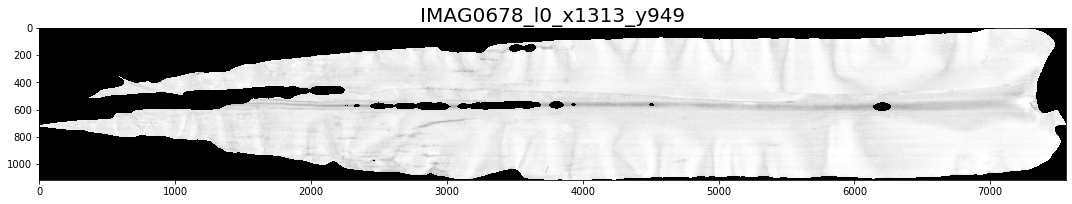

In [10]:
#tiff_file = lsrc + 'IMAG0024_l0_x1373_y1953.tif'
#tiff_file = lsrc + 'IMAG0043_l0_x955_y2498.tif'
#tiff_file = lsrc + 'IMAG0044_l0_x106_y943.tif'
#tiff_file = lsrc + 'IMAG0056_l1_x1368_y610.tif'
#tiff_file = lsrc + 'IMAG0065_l1_x1259_y1339.tif'
#tiff_file = lsrc + 'IMAG0085_l1_x351_y1829.tif'
#tiff_file = lsrc + 'IMAG0642_l1_x1406_y14.tif'
#tiff_file = lsrc + 'IMAG0668_l1_x1450_y1638.tif'
tiff_file = lsrc + 'IMAG0678_l0_x1313_y949.tif'
#tiff_file = lsrc + 'IMAG0715_l0_x864_y473.tif'

raw, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

img = tf.imread(tiff_file)

plt.figure(figsize=(15,5))
plt.imshow(img, cmap='gray')

plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

### Binarize and fill holes

- We immediately get surface area of the scan

Scan area: 6044763 pixels


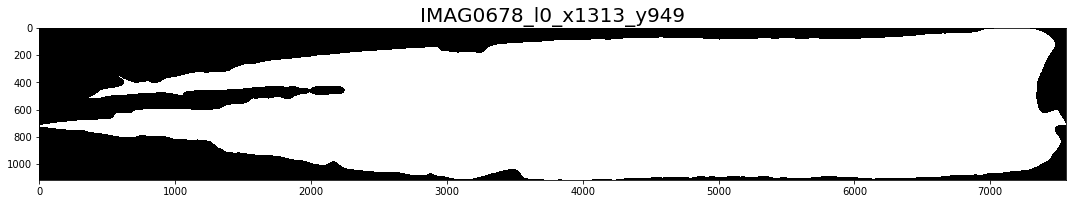

In [11]:
img[img > 0] = 1
img = ndimage.binary_fill_holes(img)
if img.shape[0] > img.shape[1]:
    img = img.T

scan_area = np.sum(img)
print('Scan area:', scan_area, 'pixels')
plt.figure(figsize=(15,5))
plt.imshow(img, cmap='gray')

plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

### With a convolution, we get the margin (border) of the binarized image
- Convolving mask takes into account 8-neighbourhood:
    $$\left[\begin{array}{c|c|c}
    	-1 & -1 & -1\\
    	\hline
    	-1 & 8 & -1\\
        \hline
        -1 & -1 & -1    	
    \end{array}\right]$$
- We immediately get the perimeter of the scan
- Since the perimeter is quite thin (just one pixel wide), it will not render properly in the notebook.


Scan perimeter: 22903 pixels


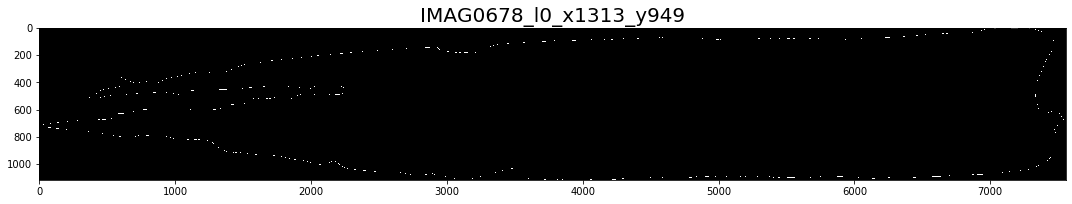

In [12]:
margin = maize.get_margin(img, border)
scan_perimeter = np.sum(margin)

print('Scan perimeter:', scan_perimeter, 'pixels')
plt.figure(figsize=(15,5))
plt.imshow(margin, cmap='gray')

plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

### Orient base to the left, tip to the right
- First we must identify the base
- The side with most pixels must be the base

Text(0.5, 1.0, '(233, 2)')

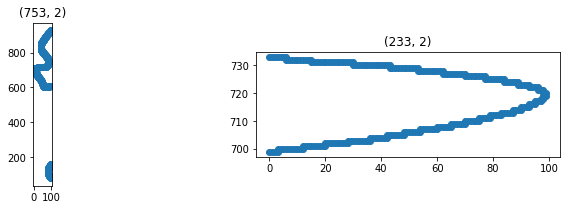

In [13]:
margin, base, tip = maize.orient_base2tip(margin)

fig,axis = plt.subplots(1,2,figsize=(12,3))

axis[0].plot(base[:,1], base[:,0], 'o')
axis[0].set_aspect('equal')
axis[0].set_title(base.shape)

axis[1].plot(tip[:,1], tip[:,0], 'o')
axis[1].set_aspect('equal')
axis[1].set_title(tip.shape)

### Compute the midrib and split the margin into top and bottom halves

- Midrib is the collection of midpoints between the top and bottom pixel at each column

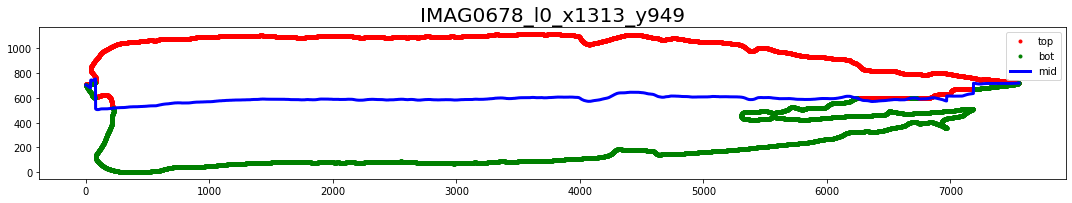

In [14]:
blades = maize.top_bot_blade(margin, border)

plt.figure(figsize=(15,5))
plt.plot(blades[0][:,0], blades[0][:,1], '.', c='r', label='top')
plt.plot(blades[1][:,0], blades[1][:,1], '.', c='g', label='bot')
plt.plot(blades[2][:,0], blades[2][:,1], lw=3, c='b', label='mid')

plt.axis('scaled')
plt.legend()
plt.title(bname, fontsize=20)
plt.tight_layout()

### Fit polynomials for top, bottom, and base
- Treat the margin as a point cloud, then fit a polynomial
    - This way we can ignore cuts and abrassions
- Treat the base independently, as it introduces too much noise when fitting the sides' polynomials

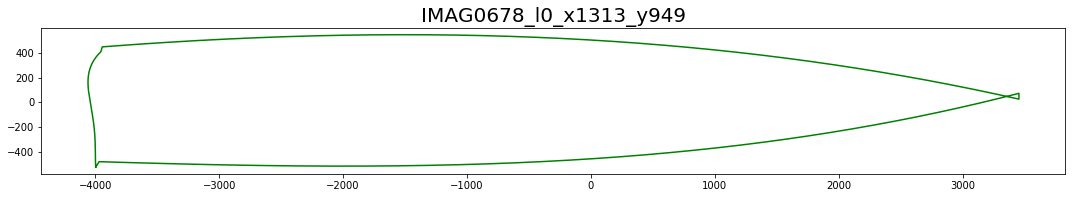

In [15]:
contour, coef, rang, pred = maize.poly_margin(margin, list(blades))

plt.figure(figsize=(15,5))
plt.plot(contour[:,0], contour[:,1], '-g')
plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

### Compute areas under each polynomial curve
- Recall that $\int_a^bp(x)dx$ is the area under the polynomial curve
- Some overlap and spillover from the tip and base
- I guess it's still good enough

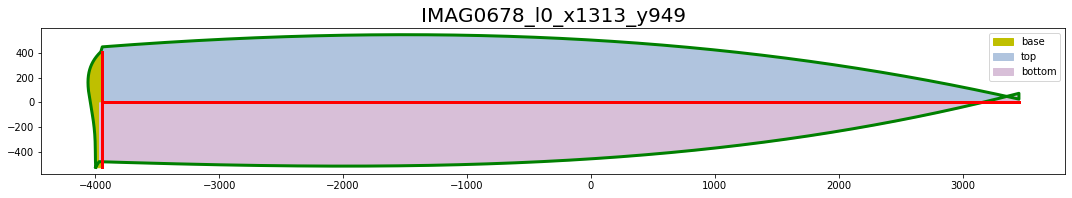

In [16]:
plt.figure(figsize=(15,5))
plt.plot(contour[:,0], contour[:,1], '-g', lw=3)

plt.fill_betweenx(contour[:len(rang[2]), 1], 
                  contour[:len(rang[2]), 0], rang[0][0],
                 label = 'base', color='y')
plt.fill_between(contour[len(rang[2]):(len(rang[0])+len(rang[2])), 0], 
                 contour[len(rang[2]):(len(rang[0])+len(rang[2])), 1], 0,
                label = 'top', color='lightsteelblue')

plt.fill_between(contour[(len(rang[0])+len(rang[2])):(len(contour)-1), 0], 
                 contour[(len(rang[0])+len(rang[2])):(len(contour)-1), 1], 0,
                label = 'bottom', color='thistle')
plt.plot([rang[0][0], rang[0][0]], [rang[2][0], rang[2][-1]] , c='r', lw=3)
plt.plot([rang[0][0], rang[0][-1]], [0, 0] , c='r', lw=3)

plt.legend()

plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

### Compute the area and perimeter of the polynomial model.
- Since we're dealing with polynomials, we can do basic calculus to find area and perimeter.
- Our model results are sensible when compared to the original values from the scan,

In [17]:
model_perimeter = maize.poly_perimeter(contour)
model_area = maize.poly_area(coef, rang)

print('PERIMETER: ', scan_perimeter, ' vs ', model_perimeter)
print('AREA: ',scan_area,' vs ', model_area)

PERIMETER:  22903  vs  16357.191292709755
AREA:  6044763  vs  6037170.178665659


### Lenght and Width of the modeled blade

In [18]:
np.max(contour, axis=0) - np.min(contour, axis=0)

array([7513.27024172, 1069.21764646])